##About
This Jupyter Notebook provides code examples for running tests on Rigetti QPUs through AWS Brakets with
the goal of providing data for cross chiplet/on chiplet swap errors, as well as an attempt to examine
errors with respect to coherence. The cross chiplet swap data provides insight into the differences in
error produced from the different swap types, however due to the AWS optimization functions and
incompatibility with Qiskit, it is unable to properly stall the circuit to examine coherence error, and therefore is a route for future improvement.

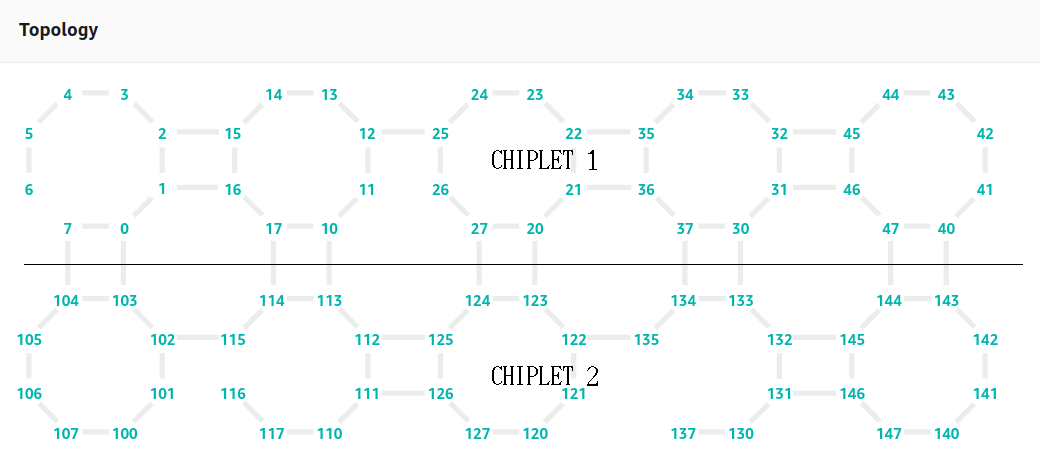

In [2]:
from braket.tracking import Tracker
t = Tracker().start()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import string
import time
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

In [3]:
# the Rigetti device
device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")
supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
# print the supported gate set
print('Gate set supported by the Rigetti device:\n', supported_gates)
print('\n') 

Gate set supported by the Rigetti device:
 ['cz', 'xy', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'y', 'z', 'start_verbatim_box', 'end_verbatim_box']




In [6]:
#Single Column of Swap Error Modelling circuit
SwapTestCircuit = Circuit()
SwapTestCircuit.h(1).cnot(control=1,target=0).cnot(control=1,target=2)
SwapTestCircuit.swap(0,103) #Cross Chiplet Swap
SwapTestCircuit.swap(2,3) #Intra Chiplet Swap
print(SwapTestCircuit)

T    : |0|1|  2   | 3  |
                        
q0   : ---X---SWAP------
          |   |         
q1   : -H-C-C-|---------
            | |         
q2   : -----X-|----SWAP-
              |    |    
q3   : -------|----SWAP-
              |         
q103 : -------SWAP------

T    : |0|1|  2   | 3  |


In [8]:
#Attempted Circuit to get around compiler optimizations
CoherenceTestCircuit = Circuit()
empty_steps = 4 #Number of timesteps to do unused work
for i in range(empty_steps):
    CoherenceTestCircuit.h(0)                 # Trick compiler into thinking it needs empty_steps more timesteps for h gates
CoherenceTestCircuit.swap(1,0)# Use swap to move q0 out of the way and make sure the compiler doesn't drop h gates
CoherenceTestCircuit.swap(2,1)# Move 2 Towards 0, use 2 instead of 1 to avoid crosstalk
#Qubit of interest is q1, as it idles for empty_steps + 1 timesteps
print(CoherenceTestCircuit)

T  : |0|1|2|3| 4  | 5  |
                        
q0 : -H-H-H-H-SWAP------
              |         
q1 : ---------SWAP-SWAP-
                   |    
q2 : --------------SWAP-

T  : |0|1|2|3| 4  | 5  |


In [ ]:
rigetti = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")

#Change these to configure which column  is being tested
center = 41
intrameasured = 42
intraswap = 43
crossmeasured = 40
crossswap = 143

# Create a clean circuit with no result type attached.(This is because some result types are only supported when shots=0)
SwapTestCircuit = Circuit()
SwapTestCircuit.h(center).cnot(control=center,target=intrameasured).cnot(control=center,target=crossmeasured)
SwapTestCircuit.swap(crossmeasured,crossswap) #Cross Chiplet Swap
SwapTestCircuit.swap(intrameasured,intraswap) #Intra Chiplet Swap

# run circuit and disable transpiler qubit rewiring to control which qubits are used
rigetti_task = rigetti.run(bell, shots=1000, disable_qubit_rewiring=True)

# get id and status of submitted task
rigetti_task_id = rigetti_task.id
rigetti_status = rigetti_task.state()
# print('ID of task:', rigetti_task_id)
print('Status of task:', rigetti_status)

In [ ]:
#Cell for initializing and running coherence time circuit
rigetti = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3")

#Change these to configure which column  is being tested

CoherenceTestCircuit = Circuit()
empty_steps = 4 #Number of timesteps to do unused work
for i in range(empty_steps):
    CoherenceTestCircuit.h(0) 
CoherenceTestCircuit.swap(1,0)
CoherenceTestCircuit.swap(2,1)

rigetti_task = rigetti.run(bell, shots=1000, disable_qubit_rewiring=False)

# get id and status of submitted task
rigetti_task_id = rigetti_task.id
rigetti_status = rigetti_task.state()
# print('ID of task:', rigetti_task_id)
print('Status of task:', rigetti_status)

In [ ]:
#Query Status
status = rigetti_task.state()
print('Status of (reconstructed) task:', status)

In [ ]:
# recover task
task_load = AwsQuantumTask(arn=rigetti_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) task:', status)
print('\n')

if status == 'COMPLETED':
    rigetti_results = task_load.result()
    
    metadata = task_load.metadata()
    shots = metadata['shots']
    machine = metadata['deviceArn']
    print("{} shots taken on machine {}.\n".format(shots, machine))
    print("The compiled circuit is:\n", rigetti_results.additional_metadata.rigettiMetadata.compiledProgram)
    rigetti_counts = rigetti_results.measurement_counts
    print('Measurement counts:', rigetti_counts)
    # plot results
    plt.bar(rigetti_counts.keys(), rigetti_counts.values())
    plt.xlabel('bitstrings')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig('rigetti.png', dpi=700)
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

In [ ]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

In [ ]:
#Post Processing for Cross Chiplet Error Models
total_shots = 1000
inter_chip_err_ct = 0
intra_chip_err_ct = 0

bit_strings = list(rigetti_counts.keys())
for bit_string in bit_strings:
    if bit_string[0] != bit_string[4]: #If control doesn't match swapped cubit, error count ++
        inter_chip_err_ct += rigetti_counts[bit_string]
    if bit_string[0] != bit_string[3]:
        intra_chip_err_ct += rigetti_counts[bit_string]

inter_chip_err_rate = inter_chip_err_ct / (total_shots)
intra_chip_err_rate = intra_chip_err_ct / (total_shots)

print("Inter-chip error count: " + str(inter_chip_err_ct))
print("Inter-chip error rate: " + str(inter_chip_err_rate))
print("Intra-chip error count: " + str(intra_chip_err_ct))
print("Intra-chip error rate: " + str(intra_chip_err_rate))

In [ ]:
#Post Processing for Coherence Time Error Modelling
counts = 0
bit_strings = list(rigetti_counts.keys())
for bit_string in bit_strings:
    if bit_string[1] != '0': #If Qubit 1  =! 0, decoherence is observed
        counts += rigetti_counts[bit_string]

print(counts)